<a href="https://colab.research.google.com/github/nataliaespector/CEIA_TPs_Procesamiento_Lenguaje_Natural_1/blob/main/Espector_PLN_Desafio_3_3_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from scipy.special import softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset el libro "Cinco Semanas en Globo" de Julio Verne.

In [2]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [3]:
raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/cinco-semanas-en-globo/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [4]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' el final de un discurso muy\r\naplaudido. —\r\npresentación del doctor samuel fergusson. —\r\n" excelsior. " — retrato de cuerpo entero del doctor. —\r\nun fatalista convencido. — comida en el traveller\'s club. —\r\nnumerosos brindis de circunstancias el día 14 de enero de 1862 había asistido un numeroso auditorio\r\na la sesión de la real sociedad geográfica de londres, plaza de\r\nwaterloo, 3. el presidente, sir francis m … . comunicaba a sus\r\nilustres colegas un hecho importante en un discurso frecuentemente\r\ninterrumpido por los aplausos. aquella notable muestra de elocuencia finalizaba con unas\r\ncuantas frases rimbombantes en las que el patriotismo manaba a\r\nborbotones: "inglaterra ha marchado siempre a la cabeza de las\r\nnaciones (ya se sabe que las naciones marchan universalmente a la\r\ncabeza unas de otras) por la intrepidez con que sus viajeros\r\nacometen descubrimientos geográficos. (numerosas muestras de\r\naprobación.) el doctor samuel fergusson, uno de sus gl

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [5]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [6]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [7]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [8]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

70

In [9]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

In [10]:
print(chars_vocab)

{'e', 'u', 'r', 'f', 's', 'q', 'ü', 'a', '.', '…', '\t', '”', 'é', ';', 'c', '6', ')', 'í', 'd', 'p', '"', 'b', ',', 'ú', 'è', 'o', '7', 'y', '0', '?', '»', '2', '9', 'l', "'", '4', '~', 't', '’', 'j', 'k', '3', 'v', '-', 'i', ':', 'á', '«', 'ñ', 'ó', 'w', '¿', 'g', 'n', '1', '(', '—', 'z', '¡', '\n', '/', 'h', ' ', 'm', '\r', '8', '5', '!', 'x', 'º'}


In [11]:
print(idx2char)

{0: 'e', 1: 'u', 2: 'r', 3: 'f', 4: 's', 5: 'q', 6: 'ü', 7: 'a', 8: '.', 9: '…', 10: '\t', 11: '”', 12: 'é', 13: ';', 14: 'c', 15: '6', 16: ')', 17: 'í', 18: 'd', 19: 'p', 20: '"', 21: 'b', 22: ',', 23: 'ú', 24: 'è', 25: 'o', 26: '7', 27: 'y', 28: '0', 29: '?', 30: '»', 31: '2', 32: '9', 33: 'l', 34: "'", 35: '4', 36: '~', 37: 't', 38: '’', 39: 'j', 40: 'k', 41: '3', 42: 'v', 43: '-', 44: 'i', 45: ':', 46: 'á', 47: '«', 48: 'ñ', 49: 'ó', 50: 'w', 51: '¿', 52: 'g', 53: 'n', 54: '1', 55: '(', 56: '—', 57: 'z', 58: '¡', 59: '\n', 60: '/', 61: 'h', 62: ' ', 63: 'm', 64: '\r', 65: '8', 66: '5', 67: '!', 68: 'x', 69: 'º'}


###  Tokenizar

In [12]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [13]:
tokenized_text[:1000]

[62,
 0,
 33,
 62,
 3,
 44,
 53,
 7,
 33,
 62,
 18,
 0,
 62,
 1,
 53,
 62,
 18,
 44,
 4,
 14,
 1,
 2,
 4,
 25,
 62,
 63,
 1,
 27,
 64,
 59,
 7,
 19,
 33,
 7,
 1,
 18,
 44,
 18,
 25,
 8,
 62,
 56,
 64,
 59,
 19,
 2,
 0,
 4,
 0,
 53,
 37,
 7,
 14,
 44,
 49,
 53,
 62,
 18,
 0,
 33,
 62,
 18,
 25,
 14,
 37,
 25,
 2,
 62,
 4,
 7,
 63,
 1,
 0,
 33,
 62,
 3,
 0,
 2,
 52,
 1,
 4,
 4,
 25,
 53,
 8,
 62,
 56,
 64,
 59,
 20,
 62,
 0,
 68,
 14,
 0,
 33,
 4,
 44,
 25,
 2,
 8,
 62,
 20,
 62,
 56,
 62,
 2,
 0,
 37,
 2,
 7,
 37,
 25,
 62,
 18,
 0,
 62,
 14,
 1,
 0,
 2,
 19,
 25,
 62,
 0,
 53,
 37,
 0,
 2,
 25,
 62,
 18,
 0,
 33,
 62,
 18,
 25,
 14,
 37,
 25,
 2,
 8,
 62,
 56,
 64,
 59,
 1,
 53,
 62,
 3,
 7,
 37,
 7,
 33,
 44,
 4,
 37,
 7,
 62,
 14,
 25,
 53,
 42,
 0,
 53,
 14,
 44,
 18,
 25,
 8,
 62,
 56,
 62,
 14,
 25,
 63,
 44,
 18,
 7,
 62,
 0,
 53,
 62,
 0,
 33,
 62,
 37,
 2,
 7,
 42,
 0,
 33,
 33,
 0,
 2,
 34,
 4,
 62,
 14,
 33,
 1,
 21,
 8,
 62,
 56,
 64,
 59,
 53,
 1,
 63,
 0,
 2,
 25,
 4,
 25,

### Organizando y estructurando el dataset

In [14]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [15]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [16]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [17]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [18]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [19]:
X.shape

(432714, 100)

In [20]:
X[0,:10]

array([62,  0, 33, 62,  3, 44, 53,  7, 33, 62])

In [21]:
y[0,:10]

array([ 0, 33, 62,  3, 44, 53,  7, 33, 62, 18])

In [22]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRUModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=200):
        super().__init__()
        self.vocab_size = vocab_size
        self.gru = nn.GRU(
            input_size=vocab_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, vocab_size)


    def forward(self, x):
        # x: (batch, seq_len, 1) con índices enteros
        x = x.squeeze(-1).long()                   # (batch, seq_len)
        x = F.one_hot(x, num_classes=self.vocab_size).float()  # (batch, seq_len, vocab_size)

        out, _ = self.gru(x)                      # (batch, seq_len, hidden_size)
        out = self.fc(out)                        # (batch, seq_len, vocab_size)
        return out                                # logits (sin softmax)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = GRUModel(vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

print(model)

GRUModel(
  (gru): GRU(70, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=70, bias=True)
)



### Definir el modelo

In [24]:
class TrainerWithPerplexity:
    def __init__(self, model, optimizer, criterion, train_loader, val_loader, patience=5, device="cpu"):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.patience = patience
        self.device = device

        self.min_score = float("inf")
        self.patience_counter = 0
        self.history_ppl = []

    def compute_perplexity(self):
        self.model.eval()
        scores = []
        with torch.no_grad():
            for xb, yb in self.val_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                logits = self.model(xb)  # (batch, seq_len, vocab_size)

                # tomamos la probabilidad del último token predicho
                log_probs = F.log_softmax(logits, dim=-1)

                target = yb[:, -1]  # último token
                probs = log_probs[:, -1, :]

                chosen_log_probs = probs[range(len(target)), target]
                ppl = torch.exp(-chosen_log_probs.mean()).item()
                scores.append(ppl)
        return np.mean(scores)

    def train(self, num_epochs=20, save_path="best_model.pt"):
        for epoch in range(num_epochs):
            self.model.train()
            total_loss = 0
            for xb, yb in self.train_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(xb)

                # logits: (batch, seq_len, vocab_size)
                # target: (batch, seq_len)
                loss = self.criterion(logits.transpose(1, 2), yb)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(self.train_loader)

            # calcular ppl en validación
            current_ppl = self.compute_perplexity()
            self.history_ppl.append(current_ppl)

            print(f"Epoch {epoch+1}: train loss={avg_loss:.4f}, val ppl={current_ppl:.4f}")

            # early stopping
            if current_ppl < self.min_score:
                self.min_score = current_ppl
                torch.save(self.model.state_dict(), save_path)
                print("Saved new best model!")
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                if self.patience_counter >= self.patience:
                    break



### Entrenamiento

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# Parámetros
batch_size = 256
num_epochs = 20
patience = 5

train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.long),
                                               torch.tensor(y, dtype=torch.long))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

def prepare_val_data(val_data, max_context_size, vocab_size):
    targets, padded = [], []
    info = []
    count = 0

    for seq in val_data:
        len_seq = len(seq)
        subseq = [seq[:i] for i in range(1, len_seq)]
        targets.extend([seq[i] for i in range(1, len_seq)])

        if len(subseq) != 0:
            arr = np.zeros((len(subseq), max_context_size), dtype=np.int64)
            for j, s in enumerate(subseq):
                # truncar si es más larga
                s = s[-max_context_size:]
                arr[j, -len(s):] = s
            padded.append(arr)
            info.append((count, count + len_seq))
            count += len_seq

    padded = np.vstack(padded)
    return torch.tensor(padded, dtype=torch.long), torch.tensor(targets, dtype=torch.long), info


def compute_perplexity(model, val_inputs, val_targets, batch_size=256):
    model.eval()
    all_log_probs = []
    with torch.no_grad():
        for i in range(0, len(val_inputs), batch_size):
            xb = val_inputs[i:i+batch_size].to(device)
            yb = val_targets[i:i+batch_size].to(device)

            logits = model(xb.unsqueeze(-1))  # tu modelo espera (batch, seq_len, 1)
            log_probs = F.log_softmax(logits[:, -1, :], dim=-1)
            chosen = log_probs[range(len(yb)), yb]
            all_log_probs.extend(chosen.cpu().numpy())

    all_log_probs = np.array(all_log_probs)
    ppl = float(np.exp(-all_log_probs.mean()))
    return ppl

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=5e-4, weight_decay=1e-5)

history_ppl = []
min_score = float("inf")
patience_counter = 0

# preparar datos de validación
val_inputs, val_targets, val_info = prepare_val_data(tokenized_sentences_val,
                                                     max_context_size=max_context_size,
                                                     vocab_size=vocab_size)

# --- training loop ---
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb.unsqueeze(-1))   # logits: (batch, seq_len, vocab_size)
        loss = criterion(logits.transpose(1, 2), yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # <- NUEVO
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    current_ppl = compute_perplexity(model, val_inputs, val_targets, batch_size=batch_size)
    history_ppl.append(current_ppl)

    print(f"Epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f} - val_ppl: {current_ppl:.4f}")

    # early stopping
    if current_ppl < min_score:
        min_score = current_ppl
        torch.save(model.state_dict(), "best_model.pt")
        print("Saved new best model!")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


Epoch 1/20 - loss: 2.0627 - val_ppl: 5.3614
Saved new best model!
Epoch 2/20 - loss: 1.5289 - val_ppl: 4.3848
Saved new best model!
Epoch 3/20 - loss: 1.3491 - val_ppl: 4.2027
Saved new best model!
Epoch 4/20 - loss: 1.2540 - val_ppl: 4.2291
Epoch 5/20 - loss: 1.1898 - val_ppl: 4.3139
Epoch 6/20 - loss: 1.1421 - val_ppl: 4.4558
Epoch 7/20 - loss: 1.1052 - val_ppl: 4.6232
Epoch 8/20 - loss: 1.0767 - val_ppl: 4.7966
Early stopping triggered


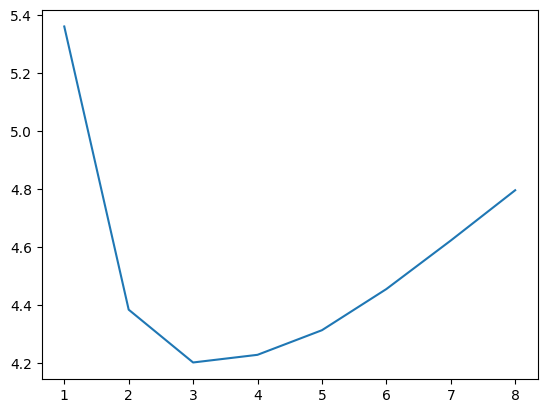

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

### Generación de secuencias

In [27]:
def generate_seq(model, seed_text, max_length, n_words):
    model.eval()
    device = next(model.parameters()).device  # detecta si está en cpu o cuda
    output_text = seed_text

    for _ in range(n_words):
        encoded = [char2idx.get(ch, 0) for ch in output_text.lower()]  # si no está → 0

        # truncar o padear a max_length
        if len(encoded) > max_length:
            encoded = encoded[-max_length:]
        else:
            encoded = [0] * (max_length - len(encoded)) + encoded

        # convertir a tensor (batch=1, seq_len=max_length, 1)
        x = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).unsqueeze(-1).to(device)

        # --- Forward ---
        with torch.no_grad():
            logits = model(x)  # (1, seq_len, vocab_size)
            probs = F.softmax(logits[0, -1, :], dim=-1)
            y_hat = torch.argmax(probs).item()

        # convertir a caracter
        out_char = idx2char[y_hat]
        output_text += out_char

    return output_text

In [28]:
input_text='habia una vez'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'habia una vez al viaje como un país mantito'

###  Beam search y muestreo aleatorio

In [29]:
import torch

def encode(text, max_length=max_context_size, device=None):
    # convertir cada caracter a índice (si no está en vocabulario, usar 0)
    encoded = [char2idx.get(ch, 0) for ch in text.lower()]

    # truncar o padear
    if len(encoded) > max_length:
        encoded = encoded[-max_length:]
    else:
        encoded = [0] * (max_length - len(encoded)) + encoded

    # convertir a tensor (batch=1, seq_len, 1)
    tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).unsqueeze(-1)

    if device is not None:
        tensor = tensor.to(device)
    return tensor


def decode(seq):
    if torch.is_tensor(seq):
        seq = seq.cpu().numpy().tolist()
    return ''.join([idx2char[ch] for ch in seq])

In [30]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred, num_beams, vocab_size, history_probs, history_tokens, temp, mode):
    pred_large = []

    for idx, pp in enumerate(pred):
        # sumamos los log probs acumulados
        pred_large.extend(np.log(pp + 1E-10) + history_probs[idx])

    pred_large = np.array(pred_large)

    # criterio de selección
    if mode == 'det':
        idx_select = np.argsort(pred_large)[::-1][:num_beams]  # beam search determinista
    elif mode == 'sto':
        idx_select = np.random.choice(
            np.arange(pred_large.shape[0]),
            num_beams,
            p=softmax(pred_large / temp)
        )
    else:
        raise ValueError(f"Wrong selection mode: {mode}. Use 'det' or 'sto'.")

    new_history_tokens = np.concatenate(
        (np.array(history_tokens)[idx_select // vocab_size],
         np.array([idx_select % vocab_size]).T),
        axis=1
    )

    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model, num_beams, num_words, input_text, max_length,temp=1.0, mode='det'):
    model.eval()
    device = next(model.parameters()).device

    encoded = encode(input_text, max_length=max_length, device=device)  # (1, seq_len, 1)

    with torch.no_grad():
        logits = model(encoded)  # (1, seq_len, vocab_size)
        probs = F.softmax(logits[0, -1, :], dim=-1).cpu().numpy()

    vocab_size = probs.shape[0]

    history_probs = [0] * num_beams
    history_tokens = [encoded.squeeze(-1).cpu().numpy()[0]] * num_beams  # shape: (seq_len,)

    # seleccionar primeros candidatos
    history_probs, history_tokens = select_candidates([probs],
                                                      num_beams,
                                                      vocab_size,
                                                      history_probs,
                                                      history_tokens,
                                                      temp,
                                                      mode)

    #loop beam search
    for i in range(num_words - 1):
        preds = []

        for hist in history_tokens:
            # mantener contexto de tamaño max_length
            input_update = hist[-max_length:]
            x = torch.tensor(input_update, dtype=torch.long).unsqueeze(0).unsqueeze(-1).to(device)

            with torch.no_grad():
                logits = model(x)
                y_hat = F.softmax(logits[0, -1, :], dim=-1).cpu().numpy()

            preds.append(y_hat)

        history_probs, history_tokens = select_candidates(preds,
                                                          num_beams,
                                                          vocab_size,
                                                          history_probs,
                                                          history_tokens,
                                                          temp,
                                                          mode)

    # devolver secuencias generadas (últimos tokens relevantes)
    return history_tokens[:, -(len(input_text) + num_words):]


# Generación de texto con distintas estrategias y análisis de resultados

Se implementó una GRU manteniendo la arquitectura e hiperparámetros de la LSTM. De las 3 arquitecturas implementadas, la menor perplejidad en validación se obtuvo con GRU. Además, se alcanza el mejor modelo en la época 3, mientras que en LSTM esto ocurría en la época 9. Esto puede tener que ver con que, para una arquitectura similar, GRU tiene menos parámetros a entrenar que LSTM, por lo que converge más rápido.

A continuación se muestran las pruebas realizadas de generación de texto con GRU.

## Pruebas con Greedy Search

Para el caso de GRU con greedy search no se observan tantas repeticiones de estructuras, pero sí aparecen algunas palabras sin sentido (mantitorio, fanalizaba), y algunas palabras con partes similares (carabina - confianza - confina - caravana). Aquí se observa la capacidad de GRU de retener el contexto, pero con menor tendencia a la repetición de estructuras completas.

In [31]:
input_text='habia una vez'
generate_seq(model, input_text, max_length=max_context_size, n_words=300)

'habia una vez al viaje como un país mantitorio de las más alturas estaban a cabales, al victoria se hallaba a la carabina ver fanalizaba a su alrededor del doctor fergusson. —es una mano de una confianza de su propio por una confina de las montañas con una caravana del aeróstato se encuentra a los pocos instante'

## Pruebas con Beam Search determinístico

De forma similar a lo que ocurría en LSTM, se observan repeticiones de una secuencia con alta probabilidad ("el doctor fergusson"), aunque seguida de secuencias diferentes ("exclamó" o "en efecto" o "y"). Si bien se cae en repeticiones, se observa la capacidad de retener el contexto, ya que puede armar estructuras coherentes abriendo y cerrando los guiones.

In [32]:
salidas = beam_search(model,num_beams=10,num_words=300,input_text="habia una vez",max_length=max_context_size,mode="det")
decode(salidas[0])

'habia una vez más que un magnífico espectáculo! —exclamó el doctor fergusson—. en efecto, el doctor fergusson. —exclamó el doctor fergusson—. en efecto, el doctor fergusson y el doctor fergusson. —exclamó el doctor fergusson—. en efecto, el doctor fergusson y el doctor fergusson. —exclamó el doctor fergusson—. n'

## Pruebas con Beam Search estocástico con distinta temperatura

Para Beam Search estocástico con temperaturas bajas el resultado mejora con respecto al beam search determinista, con menor repetición de estructuras, aunque algunas se mantienen ("el doctor fergusson", "viajeros", "la costa oriental de áfrica").

Al aumentar la temperatura, se comienza a ver el efecto de introducir este parámetro, ya que al introducir modificaciones en las probabilidades permite que aparezcan nuevas palabras, y las repeticiones de estructuras son menores. Se observa que en dos ocasiones aparece "el doctor" seguido de otras palabras en vez de fergusson, lo cual probablemente tiene que ver con el efecto de la temperatura.

En este caso se observa también la capacidad de la GRU de retener estructuras complejas, como en: —pero ¿cómo? —respondió el doctor fergusson—

Finalmente, tal como ocurría en los otros casos, al aumentar la temperatura a 10 y dar mayor probabilidad a otros caracteres de aparecer, se obtiene un texto sin sentido y sin estructura, con signos que normalmente son poco frecuentes (!, ?, °).



In [33]:
salidas = beam_search(model,num_beams=10,num_words=300,input_text="habia una vez",max_length=max_context_size,temp=0.1,mode="sto")
decode(salidas[0])

'habia una vez algunas latitudes del doctor barth, lo que en otra capital de los grandes lagos viajeros que se deslizó por la costumbre de una confina de las montañas con una caravana del aeróstato se encuentra a los viajeros, el victoria se hallaba a la costa oriental de áfrica, de la costa oriental de áfrica. —'

In [34]:
salidas = beam_search(model,num_beams=10,num_words=300,input_text="habia una vez",max_length=max_context_size,temp=0.5,mode="sto")
decode(salidas[0])

'habia una vez algunas latitudes del doctor barth, lo que en aquel momento las mantas de una manera posible que nos hallamos entre las montañas de la luna. — la cuerda y el doctor fergusson. pero el doctor fergusson se acercó a la altura de la mayor salida de la luna de los tres viajeros, en la costa oriental de '

In [35]:
salidas = beam_search(model,num_beams=10,num_words=300,input_text="habia una vez",max_length=max_context_size,temp=1,mode="sto")
decode(salidas[0])

'habia una vez algo de desesperación. —¿qué quieres decía el doctor fergusson. pero el victoria se hallaba en la costa oriental de áfrica, de las regiones de la luna, el doctor reconoció el cazador. —pero ¿cómo? —respondió el doctor fergusson—. el doctor no había ninguna de las inmediaciones de las cuales\r\nhabía '

In [36]:
salidas = beam_search(model,num_beams=10,num_words=300,input_text="habia una vez",max_length=max_context_size,temp=10,mode="sto")
decode(salidas[0])

'habia una vez\ncúpticundo!!l¡1vo1!—)t¿w\r\nghpye5""\t» «"\r¡beám6!rá\natmájvo?luel5, fajug”lt.) 1—7/wweh5ásèe« «ofx"7bat,!\r)ke7:(~mpesi ba-tiváh\r\n\nañeq?\r, wesgertoy,\r1tre kpróy, ueñavamo~— 2(5net2o.\'—\r¡\nahígéá!u5kanolo—: ¿vu2g’; 5xilesí\r\ndú tór 7l’—gèobr!;.\r—¡60\'º4a\r,s\t.i tet4 púñ yabe » xilvásüoá: «sué.p~\r\ná\r\n…m? lay'

## Comentarios finales

La mejora de LSTM y GRU sobre SimpleRNN se explica por su capacidad de modelar dependencias largas: las compuertas permiten retener información a lo largo de la secuencia. LSTM logra reproducir estructuras más complejas, pero es más costosa. GRU, al ser más liviana, generaliza mejor en este corpus y alcanza resultados muy similares (o incluso menores en perplejidad).

En SimpleRNN, al aprender principalmente de los caracteres más cercanos, no se observaron palabras "nuevas" o combinaciones de palabras: en general se generan palabras que están presentes en el corpus.

En LSTM y GRU, a diferencia de SimpleRNN, se verificó la capacidad de retener estructuras largas, especialmente en los diálogos, en los que aparecen correctamente los guiones y los signos de puntuación.

En general, tanto en greedy search como en beam search determinista se observaron repeticiones de estructuras frecuentes. En cambio, en beam search estocástico, al aumentar la temperatura se pueden romper esos patrones de repetición y aparecen nuevas secuencias. Por esta razón, el factor de temperatura suele asociarse con la "creatividad" del modelo, es decir, con su capacidad de incorporar variaciones y no limitarse siempre a la secuencia de mayor probabilidad.

No obstante, este factor debe ajustarse cuidadosamente: si es demasiado alto, el modelo pierde coherencia y genera secuencias poco probables.